In [3]:
import sys
print(sys.version)

3.10.16 | packaged by conda-forge | (main, Dec  5 2024, 14:07:43) [MSC v.1942 64 bit (AMD64)]


In [ ]:
%pip install git+https://github.com/run-llama/llama_index.git
%pip install ftfy regex tqdm
%pip install git+https://github.com/openai/CLIP.git
%pip install torch torchvision
%pip install matplotlib
%pip install -U qdrant_client
%pip install yt-dlp
%pip install opencv-python moviepy
%pip install llama-index-vector-stores-qdrant
%pip install llama-index-embeddings-clip
%pip install openai-whisper
%pip install langchain-community sentence-transformers
%pip install unstructured chromadb ollama
%pip install "numpy<2"

## Download our Youtube Video

In [4]:
import os
import cv2
import subprocess

def download_youtube_video_and_extract_frames(youtube_url, n=3):
    frames_folder_name = "frames"
    video_folder_name = "video"
    if not os.path.exists(frames_folder_name):
        os.makedirs(frames_folder_name)
    if not os.path.exists(video_folder_name):
        os.makedirs(video_folder_name)

    # Download video using yt-dlp
    video_path = os.path.join(video_folder_name, "final_video.mp4")
    subprocess.run([
        "yt-dlp",
        youtube_url,
        "-f", "mp4",
        "-o", video_path
    ], check=True)

    # Extract frames every n seconds
    video_capture = cv2.VideoCapture(video_path)
    fps = video_capture.get(cv2.CAP_PROP_FPS)
    frame_interval = int(fps * n)

    frame_count = 0
    frame_id = 0
    while True:
        ret, frame = video_capture.read()
        if not ret:
            break
        if frame_count % frame_interval == 0:
            frame_filename = os.path.join(frames_folder_name, f"frame_{frame_id:04d}.jpg")
            cv2.imwrite(frame_filename, frame)
            frame_id += 1
        frame_count += 1

    video_capture.release()
    print(f"Downloaded video to {video_folder_name} as final_video.mp4 and extracted frames to {frames_folder_name}")


In [5]:
video_url="https://www.youtube.com/watch?v=c6PlhkQtLt4"
download_youtube_video_and_extract_frames(video_url, n=3)

Downloaded video to video as final_video.mp4 and extracted frames to frames


### Plot Images

In [1]:
from PIL import Image
import matplotlib.pyplot as plt

def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if ".jpg" in img_path:
            image = Image.open(img_path)

            plt.subplot(3, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 9:
                break

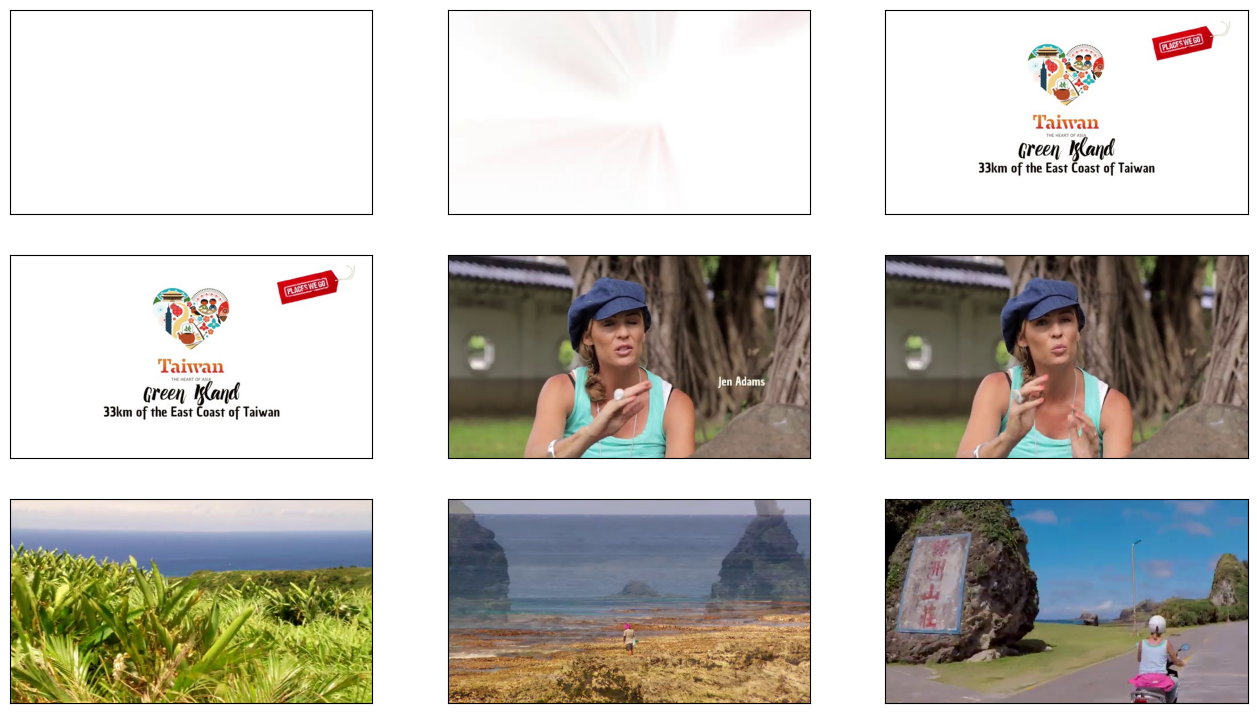

In [7]:
plot_images(["./frames/frame_0000.jpg", "./frames/frame_0001.jpg", "./frames/frame_0002.jpg", "./frames/frame_0003.jpg", "./frames/frame_0004.jpg", "./frames/frame_0005.jpg", "./frames/frame_0006.jpg", "./frames/frame_0007.jpg", "./frames/frame_0008.jpg"])

## Build Multi-modal index and vector store to index both text and images

In [2]:
!rmdir /s /q qdrant_mm_db

In [ ]:
from llama_index.core.indices.multi_modal.base import MultiModalVectorStoreIndex
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.core import SimpleDirectoryReader, StorageContext
import qdrant_client
import openai

openai.api_key = "dummy_key"        # No need to set the API key for this code, keep as is


client = qdrant_client.QdrantClient(path="qdrant_mm_db")

# Explicitly pass the necessary parameters during initialization
text_store = QdrantVectorStore(
    client=client, 
    collection_name="text_collection", 
    batch_size=64,
    max_retries=3,
)

image_store = QdrantVectorStore(
    client=client, 
    collection_name="image_collection", 
    batch_size=64,
    max_retries=3,
)

storage_context = StorageContext.from_defaults(
    vector_store=text_store, 
    image_store=image_store
)

# Create the MultiModal index
documents = SimpleDirectoryReader("./frames").load_data()

# Make sure that `from_documents` is used correctly.
index = MultiModalVectorStoreIndex.from_documents(
    documents, 
    storage_context=storage_context
)


## Testing the retrieval engine

In [4]:
retriever_engine = index.as_retriever(
    similarity_top_k=3, image_similarity_top_k=3
)
retrieval_results = retriever_engine.retrieve("mountains")

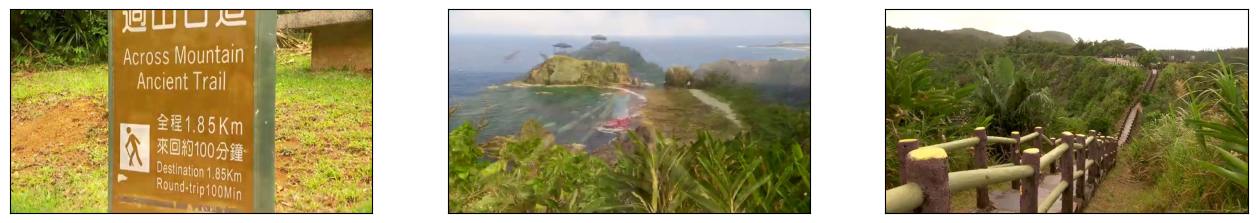

In [6]:
# To display the retrieved images

from llama_index.core.response.notebook_utils import display_source_node
from llama_index.core.schema import ImageNode

retrieved_images = []
for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode):
        retrieved_images.append(res_node.node.metadata["file_path"])
    else:
        display_source_node(res_node, source_length=200)

print(retrieved_images)
plot_images(retrieved_images)

## Extract the relevant images

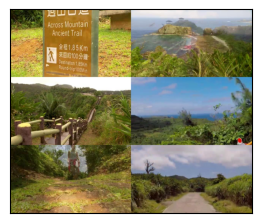

In [12]:
from PIL import Image
import os
from llama_index.core.schema import ImageNode

def retrieve_frames(query, imageGrid=True):
    image_k = 6 if imageGrid else 3

    retriever_engine = index.as_retriever(
        similarity_top_k=3, image_similarity_top_k=image_k
    )
    retrieval_results = retriever_engine.retrieve(query)

    retrieved_image = []
    for res_node in retrieval_results:
        if isinstance(res_node.node, ImageNode):
            retrieved_image.append(res_node.node.metadata["file_path"])

    if imageGrid:
        # Create an image grid of dimensions 2x3
        images = [Image.open(img) for img in retrieved_image[:6]]  # Limit to 6 images

        # Assuming all images have the same size
        img_width, img_height = images[0].size

        # Create a new image with appropriate dimensions
        grid_image = Image.new('RGB', (img_width * 2, img_height * 3))

        # Paste images into the grid
        for i, img in enumerate(images):
            grid_image.paste(img, (img_width * (i % 2), img_height * (i // 2)))

        # Create the output directory if it doesn't exist
        output_dir = 'imagegrid'
        os.makedirs(output_dir, exist_ok=True)

        # Save the grid image
        grid_image_path = os.path.join(output_dir, 'image_grid.jpg')
        grid_image.save(grid_image_path)

        # Set the relevant_images variable to the grid image
        relevant_images = SimpleDirectoryReader(input_files=[grid_image_path]).load_data()

        # Store the path of the image grid
        image_grid_path = [grid_image_path]

    else:
        relevant_images = SimpleDirectoryReader(input_files=retrieved_image).load_data()
        image_grid_path = retrieved_image

    return image_grid_path, relevant_images

plot_images(retrieve_frames("mountains")[0])

## Transcribe the audio & Store it

In [13]:
from moviepy import VideoFileClip
import whisper

# Path to the video file
video_path = "video/final_video.mp4"
audio_path = "audio.wav"
os.makedirs("transcripts", exist_ok=True)
transcript_path = "transcripts/transcript.txt"

# Step 1: Extract audio from video
def extract_audio(video_path, audio_path):
    try:
        video = VideoFileClip(video_path)
        video.audio.write_audiofile(audio_path, codec="pcm_s16le")
        print(f"Audio extracted and saved to {audio_path}")
    except Exception as e:
        print(f"Error during audio extraction: {e}")

# Step 2: Transcribe the audio into text using Whisper
def transcribe_audio(audio_path):
    try:
        model = whisper.load_model("base")  # Load the Whisper model
        result = model.transcribe(audio_path)
        return result["text"]
    except Exception as e:
        print(f"Error during transcription: {e}")
        return ""

# Step 3: Save the transcription to a text file
def save_transcription(transcription, transcript_path):
    try:
        with open(transcript_path, "w", encoding="utf-8") as f:
            f.write(transcription)
        print(f"Transcription saved to {transcript_path}")
    except Exception as e:
        print(f"Error during saving transcription: {e}")


In [ ]:
extract_audio(video_path, audio_path)
transcription = transcribe_audio(audio_path)
save_transcription(transcription, transcript_path)

In [15]:
from langchain_community.document_loaders import DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document
from langchain_community.vectorstores import Chroma
from sentence_transformers import SentenceTransformer
import os
import shutil

CHROMA_PATH = "chroma"
DATA_PATH = "transcripts"

embedding_model = SentenceTransformer('all-MiniLM-L6-v2')  # You can replace this with other models from SentenceTransformers.


class FreeEmbeddings:
    def embed_documents(self, texts: list[str]) -> list[list[float]]:
        return embedding_model.encode(texts, show_progress_bar=True).tolist()

    def embed_query(self, text: str) -> list[float]:
        return embedding_model.encode([text], show_progress_bar=False)[0].tolist()


def load_documents():
    loader = DirectoryLoader(DATA_PATH)
    documents = loader.load()
    return documents


def split_text(documents: list[Document]):
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=900,
        chunk_overlap=100,
        length_function=len,
        add_start_index=True,
    )
    chunks = text_splitter.split_documents(documents)
    print(f"Split {len(documents)} documents into {len(chunks)} chunks.")

    document = chunks[0]
    print(document.page_content)
    print(document.metadata)

    return chunks


def save_to_chroma(chunks: list[Document]):
    # Clear out the database first.
    if os.path.exists(CHROMA_PATH):
        shutil.rmtree(CHROMA_PATH)

    # Create a new DB from the documents.
    db = Chroma.from_documents(
        chunks, FreeEmbeddings(), persist_directory=CHROMA_PATH
    )
    db.persist()
    print(f"\nSaved {len(chunks)} chunks to {CHROMA_PATH}.")


In [ ]:
documents = load_documents()
chunks = split_text(documents)
save_to_chroma(chunks)

In [17]:
def retrieve_relevant_text_results(query: str, top_k: int = 5):

    # Load the existing Chroma database
    db = Chroma(
        persist_directory=CHROMA_PATH,
        embedding_function=FreeEmbeddings(),
    )
    results = db.similarity_search(query, k=top_k)
    
    return results


## Query the LLM

In [ ]:
import ollama

def query_llm(user_query):
    retrieved_results= retrieve_relevant_text_results(user_query)
    context = "\n".join(
        [f"Chunk {idx + 1}: {result.page_content}" for idx, result in enumerate(retrieved_results)]
    )
    
    image_path= retrieve_frames(user_query)[0]

    # Construct the message with the context
    response = ollama.chat(
        model="llava",
        messages=[
            {
                "role": "user",
                "content": (
                    "You are now acting as an agent, who answers questions about a video clip. "
                    "The image that you are presented with is a grid of 6 frames from the video that are relevant to the query. "
                    "The audio from the video is also transcribed, and the relevant text is given below. "
                    "Answer the query based on the context provided.\n"
                    f"Context: {context}\nQuery: {user_query}"
                ),
                "images": image_path
            }
        ]
    )
    return response['message']['content']

query="What is the video about and what landscapes are shown?"
print(query_llm(query))